# <h1><center>Gift Wonder -- Preprocessing and Modeling</center></h1>

### <center>By: Hio Wa Mak</center>

## Import packages

In [1]:
#Import pandas, matplotlib.pyplot, and seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.cluster import KMeans

## Read in the data

In [2]:
# Read in data from a csv file
gift = pd.read_csv('../data/giftdata_cleaned.csv')

### Examine details about Gift Wonder dataset

In [3]:
#Examine info on this dataset
gift.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791045 entries, 0 to 791044
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Invoice           791045 non-null  int64  
 1   Period            791045 non-null  int64  
 2   InvoiceDate       791045 non-null  object 
 3   InvoiceYearMonth  791045 non-null  int64  
 4   InvoiceYear       791045 non-null  int64  
 5   InvoiceMonth      791045 non-null  int64  
 6   InvoiceDay        791045 non-null  int64  
 7   InvoiceTime       791045 non-null  object 
 8   StockCode         791045 non-null  object 
 9   Description       791045 non-null  object 
 10  CustomerID        791045 non-null  int64  
 11  Country           791045 non-null  object 
 12  UnitPrice         791045 non-null  float64
 13  Quantity          791045 non-null  int64  
 14  TotalPrice        791045 non-null  float64
dtypes: float64(2), int64(8), object(5)
memory usage: 90.5+ MB


In [4]:
#Number of columns and observations
gift.shape

(791045, 15)

In [5]:
#Look at the first few observations
gift.head()

,Invoice,Period,InvoiceDate,InvoiceYearMonth,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceTime,StockCode,Description,CustomerID,Country,UnitPrice,Quantity,TotalPrice
0,489434,1,2009-12-01,200912,2009,12,1,07:45:00,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,13085,United Kingdom,6.95,12,83.4
1,489434,1,2009-12-01,200912,2009,12,1,07:45:00,79323P,PINK CHERRY LIGHTS,13085,United Kingdom,6.75,12,81.0
2,489434,1,2009-12-01,200912,2009,12,1,07:45:00,79323W,WHITE CHERRY LIGHTS,13085,United Kingdom,6.75,12,81.0
3,489434,1,2009-12-01,200912,2009,12,1,07:45:00,22041,"RECORD FRAME 7"" SINGLE SIZE",13085,United Kingdom,2.10,48,100.8
4,489434,1,2009-12-01,200912,2009,12,1,07:45:00,21232,STRAWBERRY CERAMIC TRINKET BOX,13085,United Kingdom,1.25,24,30.0


In [6]:
gift.tail()

,Invoice,Period,InvoiceDate,InvoiceYearMonth,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceTime,StockCode,Description,CustomerID,Country,UnitPrice,Quantity,TotalPrice
791040,581587,2,2011-12-09,201112,2011,12,9,12:50:00,22899,CHILDREN'S APRON DOLLY GIRL,12680,France,2.10,6,12.6
791041,581587,2,2011-12-09,201112,2011,12,9,12:50:00,23254,CHILDRENS CUTLERY DOLLY GIRL,12680,France,4.15,4,16.6
791042,581587,2,2011-12-09,201112,2011,12,9,12:50:00,23255,CHILDRENS CUTLERY CIRCUS PARADE,12680,France,4.15,4,16.6
791043,581587,2,2011-12-09,201112,2011,12,9,12:50:00,22138,BAKING SET 9 PIECE RETROSPOT,12680,France,4.95,3,14.8
791044,581587,2,2011-12-09,201112,2011,12,9,12:50:00,POST,POSTAGE,12680,France,18.00,1,18.0


### Convert Data Type

In [7]:
# Change `InvoiceDate` to datetime objects
gift["InvoiceDate"] = pd.to_datetime(gift["InvoiceDate"])

# Convert `CustomerID` and `Invoice` into objects
gift["CustomerID"] = gift["CustomerID"].astype(str)
gift["Invoice"] = gift["Invoice"].astype(str)
gift["Period"] = gift["Period"].astype(str)
gift.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791045 entries, 0 to 791044
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Invoice           791045 non-null  object        
 1   Period            791045 non-null  object        
 2   InvoiceDate       791045 non-null  datetime64[ns]
 3   InvoiceYearMonth  791045 non-null  int64         
 4   InvoiceYear       791045 non-null  int64         
 5   InvoiceMonth      791045 non-null  int64         
 6   InvoiceDay        791045 non-null  int64         
 7   InvoiceTime       791045 non-null  object        
 8   StockCode         791045 non-null  object        
 9   Description       791045 non-null  object        
 10  CustomerID        791045 non-null  object        
 11  Country           791045 non-null  object        
 12  UnitPrice         791045 non-null  float64       
 13  Quantity          791045 non-null  int64         
 14  Tota

## Create Customer Segmentation Variables

### Three main variables: 
### Recency, Frequency, and Monetary Value (RFM)

**Recency** -- the number of days passed since the last purchase during the two-year period <br>
**Frequency** -- the total number of purchases made during the two-year period <br>
**Monetary Value** -- the total amount of money a customer spent during the two-year period <br>

In [8]:
giftdata = gift.copy()

### Compute RFM Metrics at CustomerID Level
max_date = giftdata["InvoiceDate"].max()

rfm = giftdata.groupby("CustomerID").agg(
    Recency=("InvoiceDate", lambda x: (max_date - x.max()).days),  # Days since last purchase
    Frequency=("Invoice", "nunique"),  # Unique invoice count per customer
    Monetary=("TotalPrice", "sum")  # Total spending per customer
).reset_index()

### Compute Z-score for RFM before using K-means clustering because distance-based clustering is sensitive to scale
# Compute Z-Scores for Recency, Frequency, and Monetary
rfm["Recency_z"] = (rfm["Recency"] - rfm["Recency"].mean()) / rfm["Recency"].std()
rfm["Frequency_z"] = (rfm["Frequency"] - rfm["Frequency"].mean()) / rfm["Frequency"].std()
rfm["Monetary_z"] = (rfm["Monetary"] - rfm["Monetary"].mean()) / rfm["Monetary"].std()

print(rfm)

     CustomerID  Recency  Frequency  Monetary  Recency_z  Frequency_z  \
0         12346      325         12   77556.8   0.592935     0.438961   
1         12347        2          8    4921.5  -0.949907     0.131491   
2         12348       75          5    2019.9  -0.601215    -0.099112   
3         12349       18          4    4428.5  -0.873481    -0.175979   
4         12350      310          1     334.4   0.521286    -0.406582   
...         ...      ...        ...       ...        ...          ...   
5873      18283        3         22    2734.1  -0.945130     1.207635   
5874      18284      431          1     461.7   1.099254    -0.406582   
5875      18285      660          1     427.0   2.193095    -0.406582   
5876      18286      476          2    1296.6   1.314201    -0.329714   
5877      18287       42          7    4182.8  -0.758843     0.054623   

      Monetary_z  
0       5.163242  
1       0.135382  
2      -0.065468  
3       0.101257  
4      -0.182139  
...      

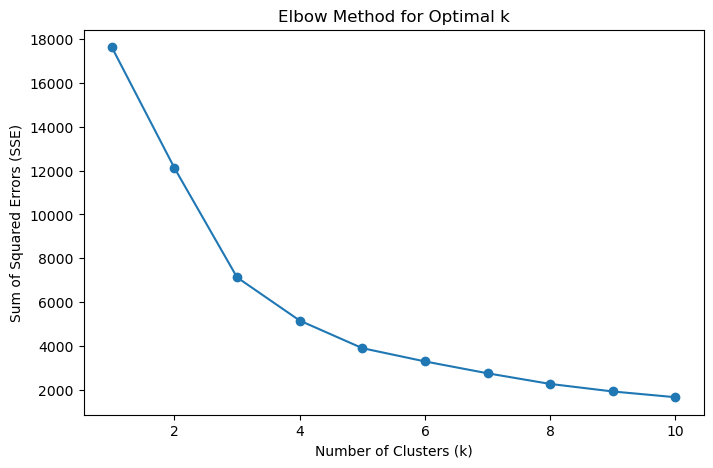

In [9]:
# Create clusters using K-means clustering
# Select only RFM Z-score columns for clustering
rfm_features = rfm[["Recency_z", "Frequency_z", "Monetary_z"]]

# Determine optimal k using the elbow method
# Compute Sum of Squared Errors (SSE) for different k values
sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_features)
    sse.append(kmeans.inertia_)  # Inertia = within-cluster sum of squares

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method for Optimal k")
plt.show()

In [10]:
# Choose the optimal number of clusters based on the Elbow Method
# At around 5 clusters, the SSE decrease more slowly
optimal_k = 5

# Apply K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(rfm_features)

# Display clustered data
print(rfm.head())

  CustomerID  Recency  Frequency  Monetary  Recency_z  Frequency_z  \
0      12346      325         12   77556.8   0.592935     0.438961   
1      12347        2          8    4921.5  -0.949907     0.131491   
2      12348       75          5    2019.9  -0.601215    -0.099112   
3      12349       18          4    4428.5  -0.873481    -0.175979   
4      12350      310          1     334.4   0.521286    -0.406582   

   Monetary_z  Cluster  
0    5.163242        1  
1    0.135382        4  
2   -0.065468        4  
3    0.101257        4  
4   -0.182139        0  


## Cluster Results

### Cluster Characteristics in Z-Scores

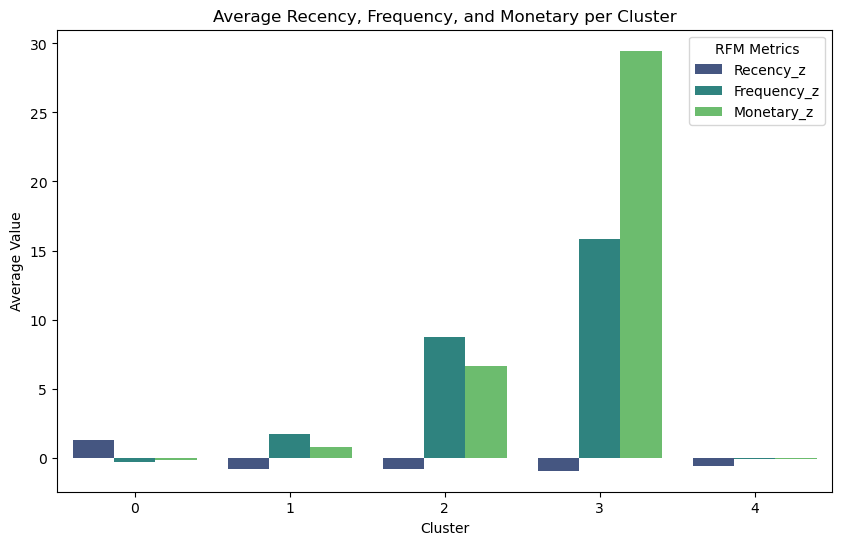

In [11]:
# Compute mean RFM values per cluster
rfm_cluster_avg = rfm.groupby("Cluster")[["Recency_z", "Frequency_z", "Monetary_z"]].mean().reset_index()

# Melt data for easier plotting
rfm_melted = rfm_cluster_avg.melt(id_vars=["Cluster"], var_name="Metric", value_name="Value")

# Plot clustered bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x="Cluster", y="Value", hue="Metric", data=rfm_melted, palette="viridis")

# Formatting
plt.xlabel("Cluster")
plt.ylabel("Average Value")
plt.title("Average Recency, Frequency, and Monetary per Cluster")
plt.legend(title="RFM Metrics")
plt.show()

**Note:** More recent customers has lower recency value.

### Cluster Characteristics in Original Units

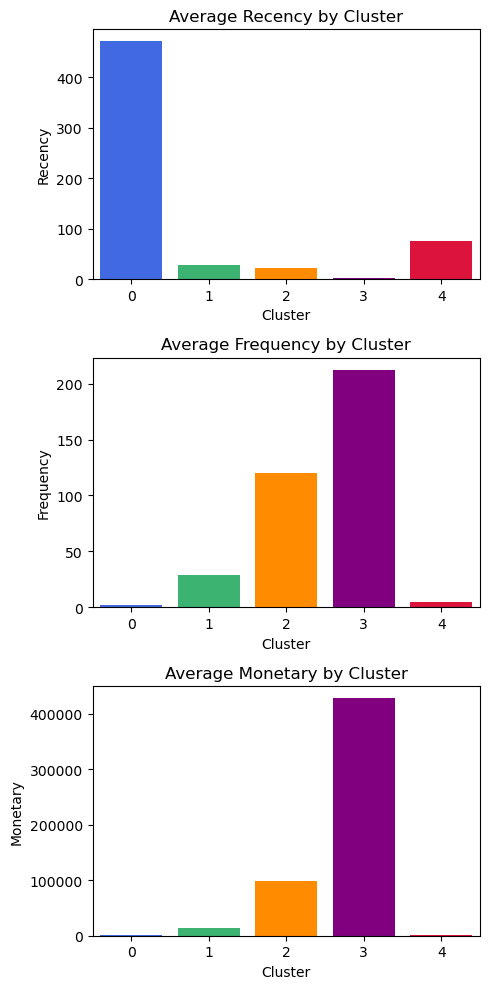

In [12]:
# Compute mean values per cluster
rfm_cluster_avg = rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean().reset_index()

# Define a consistent color mapping for clusters (5 distinct colors)
cluster_colors = {
    0: "royalblue",  # Blue
    1: "mediumseagreen",  # Green
    2: "darkorange",  # Orange
    3: "purple",  # Purple
    4: "crimson"  # Red
}

# Create a color palette using the cluster colors
palette = [cluster_colors[i] for i in sorted(rfm_cluster_avg["Cluster"].unique())]

# Set up figure with 3 rows, 1 column (vertical stacking)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))

# Plot Recency
sns.barplot(x="Cluster", y="Recency", hue="Cluster", data=rfm_cluster_avg, palette=palette, ax=axes[0], legend=False, saturation=1)
axes[0].set_title("Average Recency by Cluster")
axes[0].set_ylabel("Recency")

# Plot Frequency
sns.barplot(x="Cluster", y="Frequency", hue="Cluster", data=rfm_cluster_avg, palette=palette, ax=axes[1], legend=False, saturation=1)
axes[1].set_title("Average Frequency by Cluster")
axes[1].set_ylabel("Frequency")

# Plot Monetary
sns.barplot(x="Cluster", y="Monetary", hue="Cluster", data=rfm_cluster_avg, palette=palette, ax=axes[2], legend=False, saturation=1)
axes[2].set_title("Average Monetary by Cluster")
axes[2].set_ylabel("Monetary")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


**Note:** More recent customers has lower recency value.

In [13]:
# Cluster size
rfm["Cluster"].value_counts()

Cluster
4    3556
0    1914
1     380
2      24
3       4
Name: count, dtype: int64

## The Five Clusters are:

**Cluster 0:** Lost Low-Value Customers (N = 1914) <br>
**Cluster 1:** Recent Low-Value Recurrent Customers (N = 380) <br>
**Cluster 2:** Recent Moderate-Value Recurrent Customers (N = 24) <br>
**Cluster 3:** Very Recent High-Value Recurrent Customers (N = 4) <br>
**Cluster 4:** Infrequent Low-Value Customers (N = 3556)

### Merge RFM and their z-scores back into the original long dataset

In [14]:
# Merge RFM and their z-scores back into the original long dataset
giftdata = giftdata.merge(
    rfm[["CustomerID", "Recency", "Recency_z", "Frequency", "Frequency_z", "Monetary", "Monetary_z", "Cluster"]],
    on="CustomerID", how="left"
)

giftdata.head()

,Invoice,Period,InvoiceDate,InvoiceYearMonth,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceTime,StockCode,Description,...,UnitPrice,Quantity,TotalPrice,Recency,Recency_z,Frequency,Frequency_z,Monetary,Monetary_z,Cluster
0,489434,1,2009-12-01,200912,2009,12,1,07:45:00,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,...,6.95,12,83.4,157,-0.209534,8,0.131491,2433.1,-0.036866,4
1,489434,1,2009-12-01,200912,2009,12,1,07:45:00,79323P,PINK CHERRY LIGHTS,...,6.75,12,81.0,157,-0.209534,8,0.131491,2433.1,-0.036866,4
2,489434,1,2009-12-01,200912,2009,12,1,07:45:00,79323W,WHITE CHERRY LIGHTS,...,6.75,12,81.0,157,-0.209534,8,0.131491,2433.1,-0.036866,4
3,489434,1,2009-12-01,200912,2009,12,1,07:45:00,22041,"RECORD FRAME 7"" SINGLE SIZE",...,2.10,48,100.8,157,-0.209534,8,0.131491,2433.1,-0.036866,4
4,489434,1,2009-12-01,200912,2009,12,1,07:45:00,21232,STRAWBERRY CERAMIC TRINKET BOX,...,1.25,24,30.0,157,-0.209534,8,0.131491,2433.1,-0.036866,4


### Compute Additional Variables

In [15]:
# Compute total revenue per Invoice
giftdata["InvoiceRevenue"] = giftdata.groupby("Invoice")["TotalPrice"].transform("sum")

# Display the updated dataset
giftdata.head()

,Invoice,Period,InvoiceDate,InvoiceYearMonth,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceTime,StockCode,Description,...,Quantity,TotalPrice,Recency,Recency_z,Frequency,Frequency_z,Monetary,Monetary_z,Cluster,InvoiceRevenue
0,489434,1,2009-12-01,200912,2009,12,1,07:45:00,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,...,12,83.4,157,-0.209534,8,0.131491,2433.1,-0.036866,4,505.3
1,489434,1,2009-12-01,200912,2009,12,1,07:45:00,79323P,PINK CHERRY LIGHTS,...,12,81.0,157,-0.209534,8,0.131491,2433.1,-0.036866,4,505.3
2,489434,1,2009-12-01,200912,2009,12,1,07:45:00,79323W,WHITE CHERRY LIGHTS,...,12,81.0,157,-0.209534,8,0.131491,2433.1,-0.036866,4,505.3
3,489434,1,2009-12-01,200912,2009,12,1,07:45:00,22041,"RECORD FRAME 7"" SINGLE SIZE",...,48,100.8,157,-0.209534,8,0.131491,2433.1,-0.036866,4,505.3
4,489434,1,2009-12-01,200912,2009,12,1,07:45:00,21232,STRAWBERRY CERAMIC TRINKET BOX,...,24,30.0,157,-0.209534,8,0.131491,2433.1,-0.036866,4,505.3


#### Average Invoice Revenue Per Cluster

   Cluster  InvoiceRevenue
0        0      342.383253
1        1      478.820018
2        2      827.291548
3        3     2017.368588
4        4      368.353878


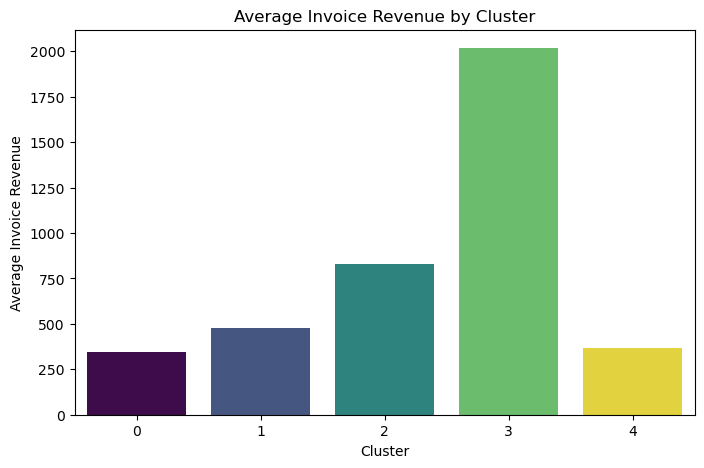

In [16]:
# Aggregate to ensure each invoice contributes only once
invoice_level_data = giftdata.groupby(["Cluster", "Invoice"])["InvoiceRevenue"].first().reset_index()

# Compute mean InvoiceRevenue per cluster (ensuring one contribution per invoice)
cluster_invoice_avg = invoice_level_data.groupby("Cluster")["InvoiceRevenue"].mean().reset_index()

# Display the computed means
print(cluster_invoice_avg)

# Set figure size
plt.figure(figsize=(8, 5))

# Create barplot for InvoiceRevenue by Cluster
sns.barplot(x="Cluster", y="InvoiceRevenue", hue="Cluster", data=cluster_invoice_avg, palette="viridis", legend=False)

# Formatting
plt.xlabel("Cluster")
plt.ylabel("Average Invoice Revenue")
plt.title("Average Invoice Revenue by Cluster")
plt.xticks(rotation=0)  # Ensure labels are horizontal
plt.show()

The three groups of low-value customers (Cluster 0, 1, 4) also spend less on average for each invoice. The moderate-value (Cluster2) customers tend to spend moderate amount on average for each invoice. The high-value (Cluster 3) customers tend to spend the most on average for each invoice.

### Total Revenue by Clusters

   Cluster  TotalRevenue  RevenuePercentage
0        0     1420890.5           8.150895
1        1     5207167.7          29.870760
2        2     2378463.2          13.643982
3        3     1714763.3           9.836688
4        4     6711039.3          38.497674


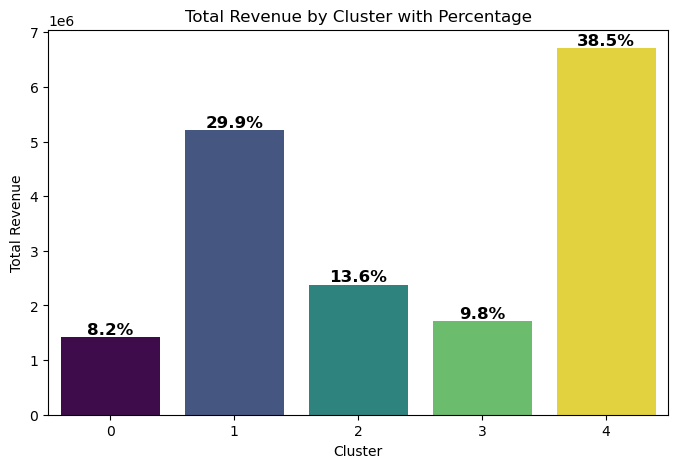

In [17]:
# Compute total revenue (sum of TotalPrice) per cluster
cluster_revenue = giftdata.groupby("Cluster")["TotalPrice"].sum().reset_index()

# Compute percentage of total revenue
cluster_revenue["RevenuePercentage"] = (cluster_revenue["TotalPrice"] / cluster_revenue["TotalPrice"].sum()) * 100

# Rename columns for clarity
cluster_revenue.rename(columns={"TotalPrice": "TotalRevenue"}, inplace=True)

# Display computed revenue with percentages
print(cluster_revenue)

# Set figure size
plt.figure(figsize=(8, 5))

# Create bar plot for total revenue by cluster
ax = sns.barplot(x="Cluster", y="TotalRevenue", hue="Cluster", data=cluster_revenue, palette="viridis", legend=False)

# Iterate through both patches and DataFrame values
for p, percentage in zip(ax.patches, cluster_revenue["RevenuePercentage"]):
    ax.annotate(f"{percentage:.1f}%", 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black', weight='bold')

# Formatting
plt.xlabel("Cluster")
plt.ylabel("Total Revenue")
plt.title("Total Revenue by Cluster with Percentage")
plt.xticks(rotation=0)  # Keep labels horizontal
plt.show()


### Save the Datasets

In [18]:
#Path
path = 'D:\\Springboard\\Projects\\capstone3\\Gift_Online_Business\\data\\'

# Save data as a csv file
giftdata.to_csv(path+'gift_cluster_long.csv', index=False)
rfm.to_csv(path+'gift_cluster_customer_level.csv', index=False)

## Summary

In the preprocessing stage, the primary goal is to prepare the dataset for K-Means clustering. A crucial step in this process is generating recency, frequency, and monetary value (RFM) variables for customer segmentation. One major challenge is that the data is in a long format, where each row represents an item in an invoice, and customers can have multiple invoices. In other words, items are nested within invoices, which are further nested within customers. The RFM variables are at the customer level.

First, I calculated the three RFM variables and standardized them using z-scores to ensure comparability when applying distance-based K-Means clustering.

Next, I determined the optimal number of clusters using the elbow method based on the sum of squared errors, identifying five as the optimal number. A K-Means model with five clusters was then fitted to the data, and the resulting clusters were merged with the RFM dataset for further analysis.

Then, I examined the RFM characteristics of the 5 clusters. The five clusters identified are:  <br>
- **Cluster 0:** Lost Low-Value Customers (N = 1914) <br>
- **Cluster 1:** Recent Low-Value Recurrent Customers (N = 380) <br>
- **Cluster 2:** Recent Moderate-Value Recurrent Customers (N = 24) <br>
- **Cluster 3:** Very Recent High-Value Recurrent Customers (N = 4) <br>
- **Cluster 4:** Infrequent Low-Value Customers (N = 3556) <br>

Beyond customer-level RFM analysis, I integrated the clusters into the original long-format dataset to gain deeper insights.

**Spending Behavior Analysis** <br>
I examined how the five customer segments differed in their average invoice spending:  <br>
- The three low-value clusters (Clusters 0, 1, and 4) had the highest customer counts but spent the least per invoice. <br>
- Cluster 2 (Moderate-Value Customers) showed moderate spending per invoice. <br>
- Cluster 3 (High-Value Customers) had the fewest customers but the highest spending per invoice. <br>

**Revenue Contribution by Cluster** <br>
Lastly, I examined Gift Wonder's total revenue by cluster across the two-year period. I found that:  <br>
- Clusters 2 & 3 (High- and Moderate-Value Customers), despite comprising just 28 of 5,878 customers (0.47%), contributed 23.4% (13.6% + 9.8%) of total revenue.  <br>
- Clusters 1 & 4 (Recent & Infrequent Low-Value Customers), making up 67% of customers (3,936 total), generated 68.4% (29.9% + 38.5%) of revenue.  <br>
- Cluster 0 (Lost Low-Value Customers) accounted for 8.2% of total revenue.  <br>

This segmentation highlights the disproportionate impact of high-value customers on revenue and provides strategic insights for targeted customer retention and marketing efforts.